# Systems Definition
The information we use in our deterministic model is given from the work done in there paper

![title](Resources/hydro_system.png)

![title](Resources/hydro_system_data.png)



# Implementation

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
from gamspy import Container, Set, Parameter, Sum, Variable, Equation, Model, Ord, Sense, Options

In [2]:
# Use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "axes.titlesize": 18,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

## Parameters

In [3]:
# given in system definition + the following
wind_production_data = (
    [(str(hour), 0) for hour in range(1, 7)] +
    [(str(hour), 0) for hour in range(7, 13)] +
    [(str(hour), 0) for hour in range(13, 19)] +
    [(str(hour), 0) for hour in range(19, 25)]
    )
demand_data = (
    [(str(hour), 50) for hour in range(1, 7)] +
    [(str(hour), 100) for hour in range(7, 13)] +
    [(str(hour), 100) for hour in range(13, 19)] +
    [(str(hour), 50) for hour in range(19, 25)]
    )
electricity_sell_price_data = (
    [(str(hour), 1) for hour in range(1, 7)] +
    [(str(hour), 1) for hour in range(7, 13)] +
    [(str(hour), 1) for hour in range(13, 19)] +
    [(str(hour), 1) for hour in range(19, 25)]
    )
electricity_buy_price_data = (
    [(str(hour), 3) for hour in range(1, 7)] +
    [(str(hour), 3) for hour in range(7, 13)] +
    [(str(hour), 3) for hour in range(13, 19)] +
    [(str(hour), 3) for hour in range(19, 25)]
    )


## Model Construction

In [4]:
# Create a GAMS container
container = Container()

In [5]:
# Define sets
t = Set(container, name="t", records=[f"{i}" for i in range(1, 25)], description="Time periods (1 to 24)")
j = Set(container, name="j", records=["V1", "V2", "V3"], description="Reservoirs")
i = Set(container, name="i", records=["c1", "c2", "c3", "c4", "c5"], description="Arcs (hydro flows)")

In [6]:
# Define parameters
A = Parameter(
    container, 
    name="A", 
    domain=[i,j], 
    records=[
        ("c1", "V1", -1), ("c1", "V2", 1), ("c1", "V3", 0),
        ("c2", "V1", 1), ("c2", "V2", -1), ("c2", "V3", 0),
        ("c3", "V1", 0), ("c3", "V2", -1), ("c3", "V3", 1),
        ("c4", "V1", 0), ("c4", "V2", 0), ("c4", "V3", -1),
        ("c5", "V1", 0), ("c5", "V2", -1), ("c5", "V3", 1),
    ], 
    description="Energy coefficients for hydro flows (MWh per 1000m³)"
    )
k = Parameter(
    container, 
    name="k", 
    domain=[i], 
    records=[("c1", 1.0), ("c2", -1.7), ("c3", 1.1), ("c4", 0.9), ("c5", 0)], 
    description="Energy coefficients for hydro flows (MWh per 1000m³)"
    )
q_max = Parameter(
    container, name="q_max", domain=[i], 
    records=[("c1", 100), ("c2", 50), ("c3", 150), ("c4", 120), ("c5", 50)], 
    description="Max flow capacity [1000 m³/h]"
    )
v_init = Parameter(container, name="v_init", domain=[j], records=[("V1", 100), ("V2", 1000), ("V3", 1000)], description="Initial storage volume [1000 m³]")
v_max = Parameter(container, name="v_max", domain=[j], records=[("V1", 1000), ("V2", 2000), ("V3", 2000)], description="Max storage volume [1000 m³]")
v_min = Parameter(container, name="v_min", domain=[j], records=[("V1", 0), ("V2", 500), ("V3", 500)], description="Min storage volume [1000 m³]")
Fj_t = Parameter(
    container, 
    name="Fj_t", 
    domain=[j, t], 
    records=[("V1", f"{hour}", 1) for hour in range(1, 25)] +
            [("V2", f"{hour}", 1) for hour in range(1, 25)] +
            [("V3", f"{hour}", 1) for hour in range(1, 25)],
    description="Natural inflow per hour [1000 m³/h]")  
cart = Parameter(
    container, 
    name="cart", 
    domain=[t], 
    records=demand_data,
    description="Bilateral contract demand [MWh]"
    ) 
WP = Parameter(
    container, 
    name="WP", 
    domain=[t], 
    records=wind_production_data,
    description="Wind power production forecast (assumed deterministic)"
    )
lambda_t = Parameter(
    container, 
    name="lambda_t", 
    domain=[t] ,
    records=electricity_sell_price_data,
    description="Electricity sell price [$CAD/MWh]"
    )
mu_t = Parameter(
    container, 
    name="mu_t", 
    domain=[t],
    records=electricity_buy_price_data,
    description="Electricity buy price [$CAD/MWh]"
    )

In [7]:
# Define variables
q = Variable(container, name="q", domain=[i, t], type="positive")  # Water flow in arc i at time t
v = Variable(container, name="v", domain=[j, t], type="positive")  # Storage volume in reservoir j at time t
buy = Variable(container, name="buy", domain=[t], type="positive")  # Electricity purchased from the market
sell = Variable(container, name="sell", domain=[t], type="positive")  # Electricity sold in the market

## Objective function & Constraints

In [8]:
# Define equations
ReservoirBalance = Equation(container, name="ReservoirBalance", domain=[j, t])  # Water balance equation
FlowLimit = Equation(container, name="FlowLimit", domain=[i, t])  # Max flow limits
StorageLimit = Equation(container, name="StorageLimit", domain=[j, t])  # Reservoir storage limits
FinalStorage = Equation(container, name="FinalStorage", domain=[j])  # Minimum storage at the end of the planning period
PowerBalance = Equation(container, name="PowerBalance", domain=[t])  # Energy balance equation

# Flow and storage limits
FlowLimit[i, t] = q[i, t] <= q_max[i]
StorageLimit[j, t] = v[j, t] <= v_max[j]
FinalStorage[j] = v[j, "24"] >= v_min[j]

# Reservoir water balance equation ((initial storage if t=1 + pervious inflow if t>1 )+ other flows)
ReservoirBalance[j, t] = v[j, t] == (
    (v_init[j]).where[Ord(t) == "1"] + (v[j, t-1]).where[Ord(t) != "1"]
    ) + Fj_t[j, t] + Sum(i, A[i,j] * q[i, t])

# Power balance equation
PowerBalance[t] = Sum(i, k[i] * q[i, t]) + WP[t] + buy[t] - sell[t] == cart[t]

# Objective function (profit maximization)
Objective = Sum(t, lambda_t[t] * sell[t] - mu_t[t] * buy[t])

# Define the model
HydroWindOptimization = Model(container, name="HydroWindOptimization", 
                              equations=container.getEquations(), 
                              problem="LP", 
                              sense=Sense.MAX, 
                              objective=Objective)

## Solving

In [9]:
# Solve the model
HydroWindOptimization.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,91.6000000000022,292,241,LP,CPLEX,0.006


## Results & Visualization

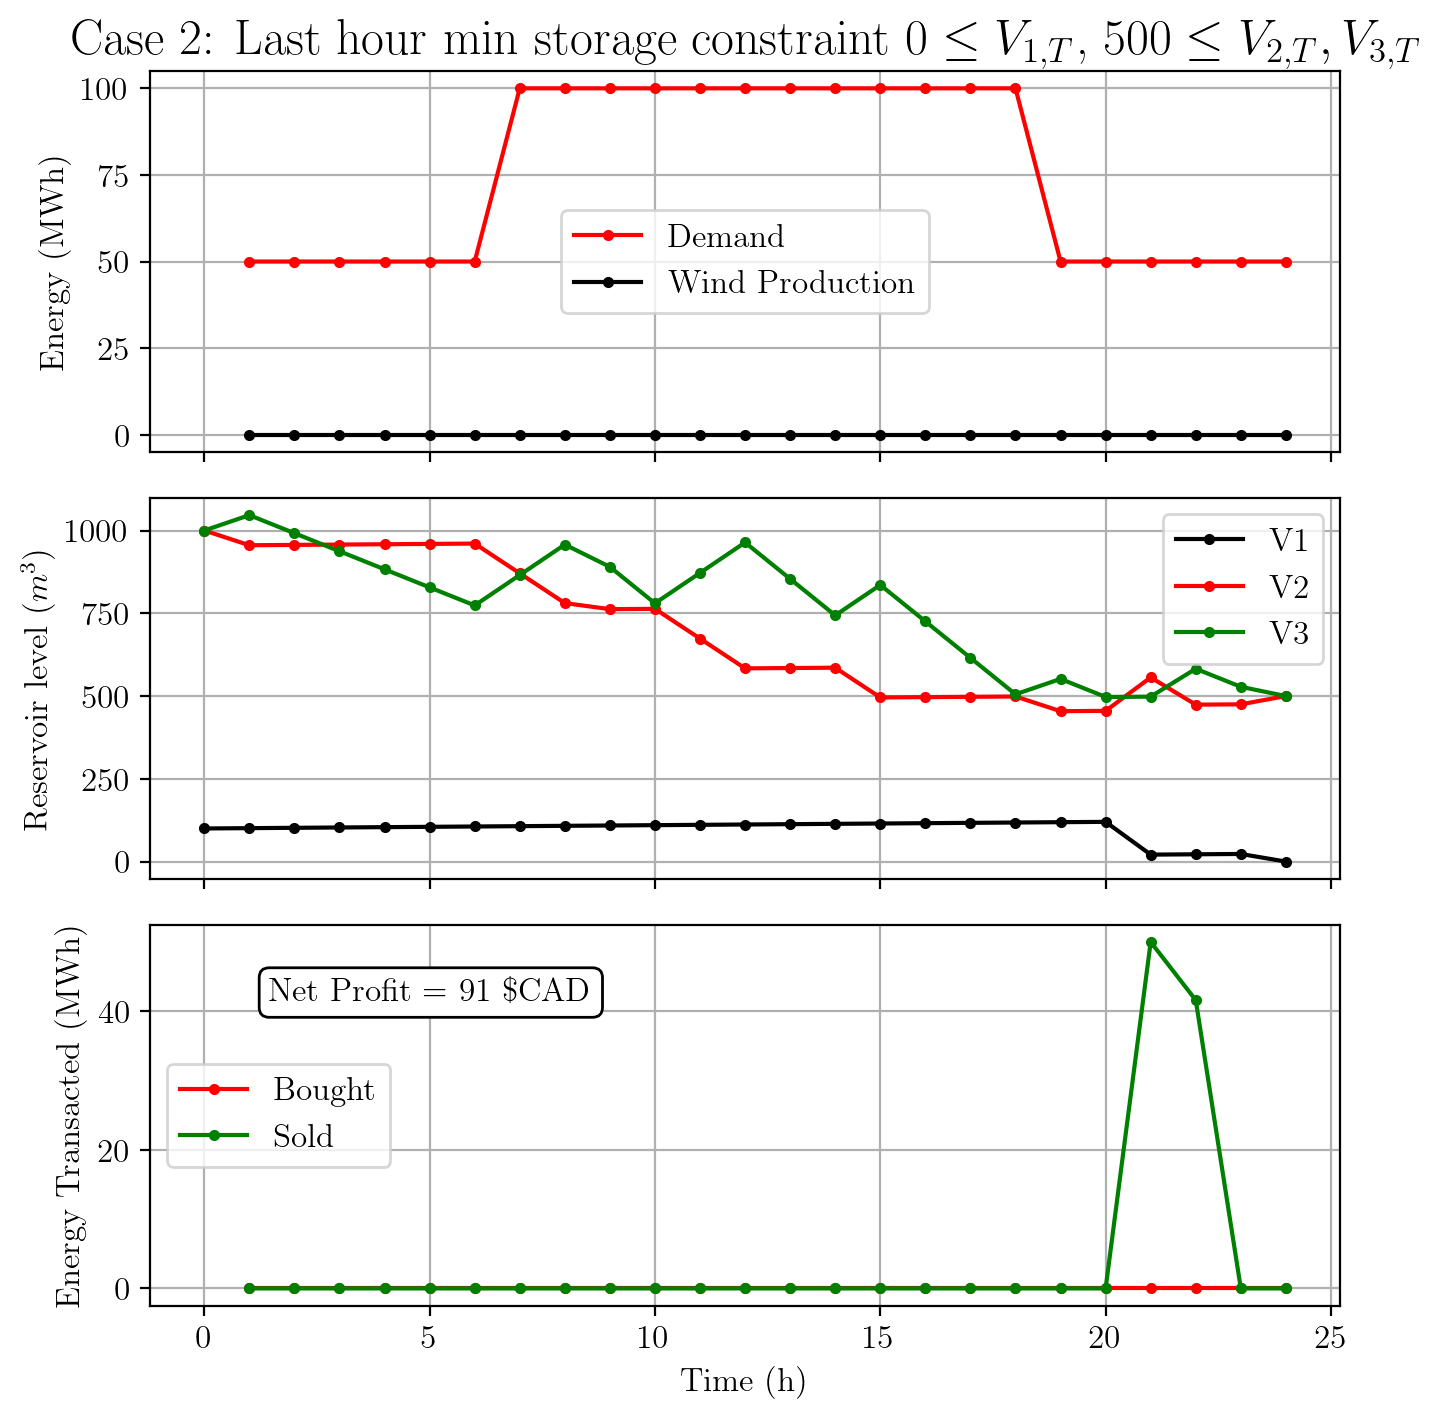

In [10]:
# Create a figure and three subplots vertically with shared x-axis
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 7), sharex=True, dpi=200)

# Plot data on each subplot
axs[0].plot(range(1,25), cart.records["value"], "-r.", label="Demand")
axs[0].plot(range(1,25), WP.records["value"], "-k.", label="Wind Production")
axs[0].set_ylabel('Energy (MWh)')
axs[0].legend()
axs[0].grid()


axs[1].plot(range(0,25),
    pd.concat([pd.Series(v_init.records["value"][0]), v.records.pivot(index="t", columns="j", values="level")["V1"]]), "-k.", label="V1")
axs[1].plot(range(0,25),
    pd.concat([pd.Series(v_init.records["value"][1]), v.records.pivot(index="t", columns="j", values="level")["V2"]]), "-r.", label="V2")
axs[1].plot(range(0,25),
    pd.concat([pd.Series(v_init.records["value"][2]),v.records.pivot(index="t", columns="j", values="level")["V3"]]), "-g.", label="V3")
axs[1].set_ylabel(r'Reservoir level $(m^3)$')
axs[1].legend()
axs[1].grid()

axs[2].plot(range(1,25), buy.records["level"], "-r.", label="Bought")
axs[2].plot(range(1,25), sell.records["level"], "-g.", label="Sold")
axs[2].annotate(f"Net Profit = {int(HydroWindOptimization.objective_value)} \$CAD", xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
axs[2].set_ylabel('Energy Transacted (MWh)')
axs[2].set_xlabel('Time (h)')
axs[2].legend()
axs[2].grid()

# Adjust layout to prevent overlap
plt.tight_layout()

axs[0].set_title(r"Case 2: Last hour min storage constraint $0\le V_{1,T}$, $500\le V_{2,T},V_{3,T}$")
# plt.xticks(np.arange(min(range(1,25)), max(range(1,25))+1))
plt.show()



# Checking Implantation

In [58]:
HydroWindOptimization.solve(output=sys.stdout, options=Options(equation_listing_limit=1000, variable_listing_limit=10))

--- Job _86c63bce-acd4-444c-aae4-8697047b3853.gms Start 02/13/25 15:06:27 48.6.0 f19e462d DAX-DAC arm 64bit/macOS
--- Applying:
    /opt/anaconda3/lib/python3.11/site-packages/gamspy_base/gmsprmun.txt
--- GAMS Parameters defined
    LP CPLEX
    Input /var/folders/3w/hd5h2k7x1vj43929dpnp39p40000gn/T/tmprt6h6x1i/_86c63bce-acd4-444c-aae4-8697047b3853.gms
    Output /var/folders/3w/hd5h2k7x1vj43929dpnp39p40000gn/T/tmprt6h6x1i/_86c63bce-acd4-444c-aae4-8697047b3853.lst
    ScrDir /var/folders/3w/hd5h2k7x1vj43929dpnp39p40000gn/T/tmprt6h6x1i/tmpuf2hudhj/
    SysDir /opt/anaconda3/lib/python3.11/site-packages/gamspy_base/
    LogOption 3
    Trace /var/folders/3w/hd5h2k7x1vj43929dpnp39p40000gn/T/tmprt6h6x1i/_86c63bce-acd4-444c-aae4-8697047b3853.txt
    License "/Users/abdelrahmanaltawil/Library/Application Support/GAMSPy/gamspy_license.txt"
    OptDir /var/folders/3w/hd5h2k7x1vj43929dpnp39p40000gn/T/tmprt6h6x1i/
    LimRow 1000
    LimCol 10
    TraceOpt 3
    GDX /var/folders/3w/hd5h2k7x1vj43

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,91.6000000000002,292,241,LP,CPLEX,0.001


In [59]:
print(HydroWindOptimization.getEquationListing())

ReservoirBalance(V1,1)..  q(c1,1) - q(c2,1) + v(V1,1) =E= 101 ; (LHS = 101)
ReservoirBalance(V1,2)..  q(c1,2) - q(c2,2) - v(V1,1) + v(V1,2) =E= 1 ; (LHS = 1)
ReservoirBalance(V1,3)..  q(c1,3) - q(c2,3) - v(V1,2) + v(V1,3) =E= 1 ; (LHS = 1)
ReservoirBalance(V1,4)..  q(c1,4) - q(c2,4) - v(V1,3) + v(V1,4) =E= 1 ; (LHS = 1)
ReservoirBalance(V1,5)..  q(c1,5) - q(c2,5) - v(V1,4) + v(V1,5) =E= 1 ; (LHS = 1)
ReservoirBalance(V1,6)..  q(c1,6) - q(c2,6) - v(V1,5) + v(V1,6) =E= 1 ; (LHS = 1)
ReservoirBalance(V1,7)..  q(c1,7) - q(c2,7) - v(V1,6) + v(V1,7) =E= 1 ; (LHS = 1)
ReservoirBalance(V1,8)..  q(c1,8) - q(c2,8) - v(V1,7) + v(V1,8) =E= 1 ; (LHS = 1)
ReservoirBalance(V1,9)..  q(c1,9) - q(c2,9) - v(V1,8) + v(V1,9) =E= 1 ; (LHS = 1)
ReservoirBalance(V1,10)..  q(c1,10) - q(c2,10) - v(V1,9) + v(V1,10) =E= 1 ; (LHS = 1)
ReservoirBalance(V1,11)..  q(c1,11) - q(c2,11) - v(V1,10) + v(V1,11) =E= 1 ; (LHS = 1)
ReservoirBalance(V1,12)..  q(c1,12) - q(c2,12) - v(V1,11) + v(V1,12) =E= 1 ; (LHS = 1)
Reservoi